In [1]:
import iCLIP
import pandas
from CGAT import GTF, IOTools

In [2]:
my_getter = iCLIP.make_getter(plus_wig="/fastdata/mbp15jdp/NUMA_ChIP/MRC5_polII_ChIP_mp/bwa.dir/MRC5_polII_ChIP_test.bw")
gtffile = IOTools.openFile("/home/mbp15jdp/devel/assorted_scripts/python_notebooks/geneset_1000_extension_filtered.gtf.gz")
gtf_iterator = GTF.iterator(gtffile)
gene_iterator = GTF.flat_gene_iterator(gtf_iterator)

In [3]:
def truncate_exon(exon, start, l, strand):
    if strand=="+":
        exon.end = min(exon.end, start+l)
    else:
        exon.start = max(exon.start, start-l)
        
    return exon

def get_pausing_ratio(transcript, getter, promoter_up_extension=100, promoter_down_extension=300, gb_start=500, gb_down_extension=2000):
    
    strand = transcript[0].strand
    
    start = min(x.start for x in transcript)
    end = max(x.end for x in transcript)
    gene_length = end - start
    
    if strand =="+":
        transcript = [truncate_exon(exon, start, gb_down_extension, "+") for exon in transcript]
        transcript = sorted(transcript, key=lambda x: x.start)
        transcript[0].start = transcript[0].start - promoter_up_extension
    else:
        transcript = [truncate_exon(exon, end, gb_down_extension, "-") for exon in transcript]
        transcript = sorted(transcript, key=lambda x: x.end)
        transcript[-1].end = transcript[-1].end + promoter_up_extension
          
    gene_counts = iCLIP.count_transcript(transcript, getter)
    gene_counts = gene_counts.sort_index()
    
    if gene_counts.sum() < 500:
        return None
    
    start = min(x.start for x in transcript)
    end = max(x.end for x in transcript)
    gene_length = end - start
    
    if gene_length < 1000:
        return None
    
    TSSR_counts = gene_counts[:(promoter_up_extension+promoter_down_extension)].sum()
    TSSR_density = TSSR_counts/(promoter_up_extension+promoter_down_extension)
    
    GBC = gene_counts[gb_start:]
    threshold =GBC.quantile(0.99)
    GBC_filtered = GBC[GBC < threshold]
    GBR_counts = GBC_filtered.sum()
    
    if GBR_counts == 0:
        return None
        
    GBR_density = GBR_counts/(gene_length-gb_start)

    pausing_ratio = TSSR_density/GBR_density

    return pausing_ratio

In [4]:
pausing_ratios = dict()
gbr_density=dict()
for gene in gene_iterator:
    pausing_ratios[gene[0].gene_id] = get_pausing_ratio(gene, my_getter)

In [12]:
pausing_ratio = pandas.Series(pausing_ratios)
pausing_ratio.head()

ENSG00000000003   NaN
ENSG00000000005   NaN
ENSG00000000938   NaN
ENSG00000000971   NaN
ENSG00000001497   NaN
dtype: float64

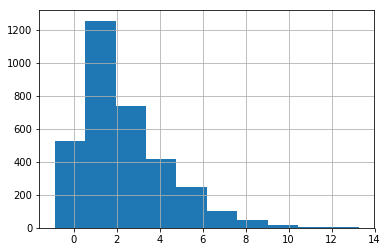

In [13]:
%matplotlib inline
pandas.np.log2(pausing_ratio+.5).hist()

In [14]:
pausing_ratio.to_csv("MRC5_RNApolII_Pausing_Ratios_hg38_1k_extension.csv", sep="\t")